Перед запуском убедитесь, что в корне проекта есть файл .env и в нем заполнены выданные вам креды подключения к базам данных и хранилищу

In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import os
import pandas as pd
from dotenv import load_dotenv, find_dotenv
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
# подгружаем .env
load_dotenv()

True

In [46]:
# Считываем все креды
src_host = os.environ.get('DB_SOURCE_HOST')
src_port = os.environ.get('DB_SOURCE_PORT')
src_username = os.environ.get('DB_SOURCE_USER')
src_password = os.environ.get('DB_SOURCE_PASSWORD')
src_db = os.environ.get('DB_SOURCE_NAME') 

dst_host = os.environ.get('DB_DESTINATION_HOST')
dst_port = os.environ.get('DB_DESTINATION_PORT')
dst_username = os.environ.get('DB_DESTINATION_USER')
dst_password = os.environ.get('DB_DESTINATION_PASSWORD')
dst_db = os.environ.get('DB_DESTINATION_NAME')

s3_bucket = os.environ.get('S3_BUCKET_NAME')
s3_access_key = os.environ.get('AWS_ACCESS_KEY_ID')
s3_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')

In [47]:
# Создадим соединения
src_conn = create_engine(f'postgresql://{src_username}:{src_password}@{src_host}:{src_port}/{src_db}')
dst_conn = create_engine(f'postgresql://{dst_username}:{dst_password}@{dst_host}:{dst_port}/{dst_db}')

### Загрузка и обзор датасета

In [48]:
# Пример выгрузки данных из БД
TABLE = 'flats_with_b_features'
SQL = f'select * from {TABLE}'
data = pd.read_sql(SQL, dst_conn)

In [49]:
display(data.head(10))
data.info()

,id,flat_id,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,price,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
0,1,0,9,9.90,19.900000,1,False,False,35.099998,9500000.0,1965,6,55.717113,37.781120,2.64,84,12,True
1,2,1,7,0.00,16.600000,1,False,False,43.000000,13500000.0,2001,2,55.794849,37.608013,3.00,97,10,True
2,3,2,9,9.00,32.000000,2,False,False,56.000000,13500000.0,2000,4,55.740040,37.761742,2.70,80,10,True
3,4,3,1,10.10,43.099998,3,False,False,76.000000,20000000.0,2002,4,55.672016,37.570877,2.64,771,17,True
4,5,4,3,3.00,14.000000,1,False,False,24.000000,5200000.0,1971,1,55.808807,37.707306,2.60,208,9,True
5,6,5,9,0.00,0.000000,2,False,False,51.009998,8490104.0,2017,4,55.724728,37.743069,2.70,192,17,True
6,7,6,1,6.18,29.340000,2,False,False,44.520000,9500000.0,1964,4,55.795589,37.722622,2.64,180,5,False
7,8,7,7,13.50,0.000000,1,False,False,52.000000,17990000.0,2015,2,55.656345,37.424335,3.00,512,11,True
8,9,8,7,8.18,19.100000,1,False,False,35.919998,6300000.0,1982,4,55.574734,37.668686,2.64,127,16,True
9,10,9,5,8.00,30.000000,2,False,False,50.000000,5900000.0,1982,4,55.994698,37.196686,2.64,142,12,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141362 entries, 0 to 141361
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 141362 non-null  int64  
 1   flat_id            141362 non-null  int64  
 2   floor              141362 non-null  int64  
 3   kitchen_area       141362 non-null  float64
 4   living_area        141362 non-null  float64
 5   rooms              141362 non-null  int64  
 6   is_apartment       141362 non-null  bool   
 7   studio             141362 non-null  bool   
 8   total_area         141362 non-null  float64
 9   price              141362 non-null  float64
 10  build_year         141362 non-null  int64  
 11  building_type_int  141362 non-null  int64  
 12  latitude           141362 non-null  float64
 13  longitude          141362 non-null  float64
 14  ceiling_height     141362 non-null  float64
 15  flats_count        141362 non-null  int64  
 16  fl

В датасете колонка `price` — это целевая переменная, а колонка `flat_id` — идентификатор квартиры

### Поиск и решение проблем в данных

Видно, что с типами данных и с пропусками проблем нет

**Дубликаты**

In [50]:
is_duplicated_id = data.duplicated(subset=['flat_id'], keep=False)
print(sum(is_duplicated_id)) 

feature_cols = data.columns.drop(["id", "flat_id"]).tolist()
is_duplicated_features = data.duplicated(subset=feature_cols, keep=False)
print(len(data[is_duplicated_features]))


0
17425


Все flat_id уникальны — дубликатов нет

Но есть дубликаты на основе равенства значений всех признаков - удалим их

In [51]:
def remove_duplicates(data):
    feature_cols = data.columns.drop(['id', 'flat_id']).tolist()
    is_duplicated_features = data.duplicated(subset=feature_cols, keep=False)
    data = data[~is_duplicated_features].reset_index(drop=True)

    return data

In [52]:

data = remove_duplicates(data)

**Пропуски**

Для оценки выбросов построим точечные диаграммы рассеяния

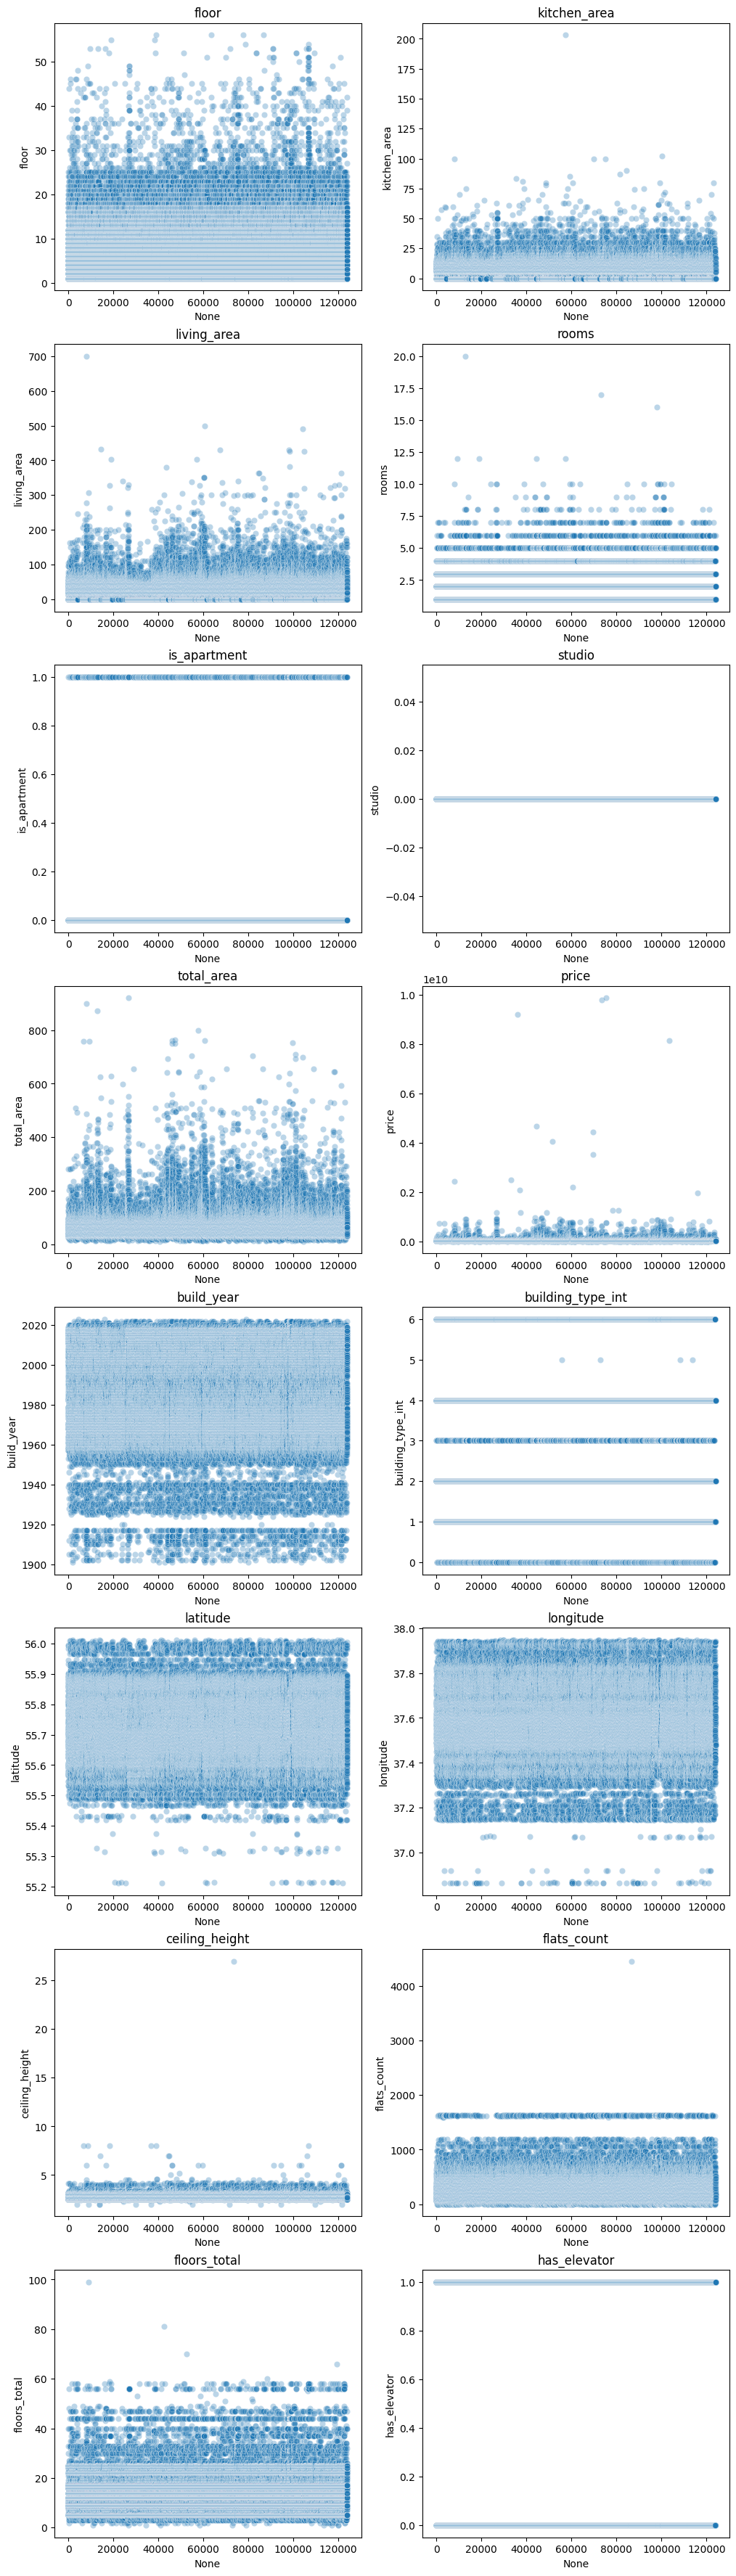

In [53]:
values_to_remove = {'id', 'flat_id'}

check_cols = [item for item in data.columns if item not in values_to_remove]

fig, ax = plt.subplots(8, 2, figsize=(12, 45))

i=0     
while i < len(check_cols):
    for row in ax:
        for ax_item in row:
            sns.scatterplot(x=data.index, y=data[check_cols[i]], alpha=0.3, ax=ax_item)
            ax_item.set_title(check_cols[i])
            i += 1

Визуально видно, что в некоторых колонках есть 

Воспользуемся статистическии методом IQR для очестки

In [54]:
num_cols = data[feature_cols].select_dtypes(["float", "int"]).columns
threshold = 1.5
potential_outliers = pd.DataFrame()

for col in num_cols:
    quartile_1 = data[col].quantile(0.25)
    quartile_3 = data[col].quantile(0.75)
    iq_range = quartile_3 - quartile_1
    margin = threshold * iq_range
    lower = quartile_1 - margin
    upper = quartile_3 + margin
    potential_outliers[col] = ~data[col].between(lower, upper)

outliers = potential_outliers.any(axis=1)

display(data[outliers])

,id,flat_id,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,price,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
3,4,3,1,10.1,43.099998,3,False,False,76.000000,20000000.0,2002,4,55.672016,37.570877,2.64,771,17,True
31,35,34,8,8.5,19.000000,1,False,False,38.000000,5800000.0,1992,4,55.983387,37.152309,2.64,379,14,True
36,42,41,24,14.0,20.000000,1,False,False,58.000000,15990000.0,2011,2,55.676590,37.634090,3.00,625,24,True
39,45,44,9,0.0,0.000000,1,False,False,40.599998,6942000.0,2017,2,55.627728,37.342995,3.00,646,9,True
42,49,48,8,14.0,64.800003,3,False,False,93.300003,37000000.0,2004,2,55.703480,37.511040,3.00,284,17,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123918,141339,141338,24,0.0,110.000000,5,False,False,184.000000,92000000.0,2010,2,55.715485,37.479034,3.00,183,24,True
123920,141341,141340,39,10.0,80.000000,2,False,False,112.000000,45000000.0,2012,2,55.744308,37.419521,3.00,332,40,True
123923,141345,141344,14,17.1,80.199997,3,False,False,136.000000,30000000.0,2005,2,55.681267,37.582401,2.80,107,17,True
123924,141346,141345,12,12.0,53.799999,3,False,False,97.239998,30990000.0,2013,4,55.683201,37.648277,2.80,524,20,True


Достаточно много выбросов присутствует в датасете - очистим

In [55]:
data = data[~outliers]

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97178 entries, 0 to 123936
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 97178 non-null  int64  
 1   flat_id            97178 non-null  int64  
 2   floor              97178 non-null  int64  
 3   kitchen_area       97178 non-null  float64
 4   living_area        97178 non-null  float64
 5   rooms              97178 non-null  int64  
 6   is_apartment       97178 non-null  bool   
 7   studio             97178 non-null  bool   
 8   total_area         97178 non-null  float64
 9   price              97178 non-null  float64
 10  build_year         97178 non-null  int64  
 11  building_type_int  97178 non-null  int64  
 12  latitude           97178 non-null  float64
 13  longitude          97178 non-null  float64
 14  ceiling_height     97178 non-null  float64
 15  flats_count        97178 non-null  int64  
 16  floors_total       97178 n

### Итог

Выявлено, что в датасете есть дубликаты и выбросы

Реализуем очистку данных в `plugins\steps\clean_churn.py`, будем использовать ее в пайплайне `dags\clean_churn.py`